<a href="https://colab.research.google.com/github/ahliminha/P300/blob/master/P300.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
!pip3 install mat4py

In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io as sio
from mat4py import loadmat 
from keras.utils import to_categorical
np.random.seed(816)

In [0]:
import glob

In [0]:
folder = '/content/drive/My Drive/IC/*.mat'
files = glob.glob(folder)
files.pop(0) #drop the data badly structured
test_file = files.pop(0) #last subject for testing the network

In [126]:
print(files)

['/content/drive/My Drive/IC/P300S03.mat', '/content/drive/My Drive/IC/P300S04.mat', '/content/drive/My Drive/IC/P300S05.mat', '/content/drive/My Drive/IC/P300S06.mat', '/content/drive/My Drive/IC/P300S07.mat', '/content/drive/My Drive/IC/P300S08.mat']


In [0]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 24.0       # sample rate, Hz
cutoff = 1.5  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

In [0]:
def prepare_data(file):
  allX = []
  allY = []
  allT = []
  allF = []
  raw_data = loadmat(file)
  useful_data = raw_data['data'].copy()
  X = useful_data['X']
  Y = useful_data['y']
  T = useful_data['trial']
  F = useful_data['flash']
  # X_mean = np.mean(X, axis=1)
  X_filtered = butter_lowpass_filter(X, cutoff, fs, order)
  
  return X_filtered, Y, T, F

In [0]:
def normalized(vec):
  norm_vec = (vec - vec.min(axis=1, keepdims=True))/vec.ptp(axis=1, keepdims=True)
  return norm_vec

In [0]:
def clean_data(X, Y, flash):
  
  X_samples = np.array([np.array(X[i[0]:i[0]+300]) for i in flash] )
  column    = [i[2] for i in flash]
  label     = [i[3] - 1 for i in flash]
  
  LIMIT = 4080 #the last trial is incomplete
  X_selected = np.array(X_samples[:LIMIT])
  col_selected = np.array(column[:LIMIT])
  label_selected = np.array(label[:LIMIT])

  y = np.array(to_categorical(label_selected))

  false_idx = [k for k, i in enumerate(y) if i[0] == 1]
  true_idx  = [k for k, i in enumerate(y) if i[0] == 0]

  falseX = X_selected[false_idx]
  falsey = y[false_idx]

  trueX  = X_selected[true_idx]  
  truey  = y[true_idx]
  # proportional data to avoid greedy cost funtion

  proportionalX = falseX[:int(len(trueX))]
  proportionaly = falsey[:int(len(truey))]

  finalX = np.concatenate((trueX, proportionalX))
  finaly = np.concatenate((truey, proportionaly))

  X_timeseries = np.vstack(finalX)
  X_letters = X_timeseries.reshape(34,40,300,8)
  y_letters = finaly.reshape(34,40,2)
  cleaned_X = np.vstack(X_letters)
  cleaned_Y = np.vstack(y_letters)
  
  return cleaned_X, cleaned_Y

In [131]:
import tensorflow as tf

from tensorflow import keras
tf.keras.backend.clear_session()  # For easy reset of notebook state.

from tensorflow.keras import layers

input_layer = keras.Input(shape = (300,8,1), name='main_input')
#lstm  = layers.Bidirectional(layers.LSTM(64, return_sequences=True))
#lstm1 = lstm(input_layer)
x     = layers.Conv2D(16, 3, activation='relu')(input_layer)
x     = layers.Conv2D(32, 3, activation='relu')(x)
x     = layers.GlobalAveragePooling2D()(x)
x     = layers.Dense(8)(x)
x     = layers.Dense(64)(x)
output = layers.Dense(2, activation='softmax')(x)

model = keras.Model(inputs=input_layer, outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 300, 8, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 298, 6, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 296, 4, 32)        4640      
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130   

In [0]:
#compiling the model
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.99, beta_2=0.9, amsgrad=True)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [0]:
from sklearn.model_selection import train_test_split
for file in files:
  X, Y, Trials, Flash = prepare_data(file)
  X_clean, y_clean = clean_data(X, Y, Flash)
  X_train, X_valid, y_train, y_valid = train_test_split(X_clean, y_clean, test_size=0.1, random_state=816)
  history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=10, epochs=20, verbose=0)
  

In [134]:
X, Y, Trials, Flash = prepare_data(test_file)
X_clean, y_clean = clean_data(X, Y, Flash)
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.1, random_state=816)
pred = model.fit(X_train, y_train, batch_size=1, epochs=20)

Epoch 1/20
1224/1224 [==============================] - 4s 4ms/step - loss: 0.6982 - accuracy: 0.5188
Epoch 2/20
1224/1224 [==============================] - 5s 4ms/step - loss: 0.6666 - accuracy: 0.6103
Epoch 3/20
1224/1224 [==============================] - 6s 5ms/step - loss: 0.6510 - accuracy: 0.6299
Epoch 4/20
1224/1224 [==============================] - 4s 4ms/step - loss: 0.6334 - accuracy: 0.6642
Epoch 5/20
1224/1224 [==============================] - 4s 4ms/step - loss: 0.5924 - accuracy: 0.7059
Epoch 6/20
1224/1224 [==============================] - 4s 4ms/step - loss: 0.5766 - accuracy: 0.7149
Epoch 7/20
1224/1224 [==============================] - 4s 4ms/step - loss: 0.5754 - accuracy: 0.7181
Epoch 8/20
1224/1224 [==============================] - 4s 4ms/step - loss: 0.5590 - accuracy: 0.7467
Epoch 9/20
1224/1224 [==============================] - 4s 4ms/step - loss: 0.5546 - accuracy: 0.7214
Epoch 10/20
1224/1224 [==============================] - 4s 4ms/step - loss: 0.552

In [135]:
score = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 7ms/step - loss: 0.5870 - accuracy: 0.7059


In [0]:
preds = model.predict(X_test)

In [0]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))

In [0]:
matrix_norm = np.zeros((2,2))
for i in range(2):
  matrix_norm[i] = matrix[i]/matrix[i].sum(axis=0)

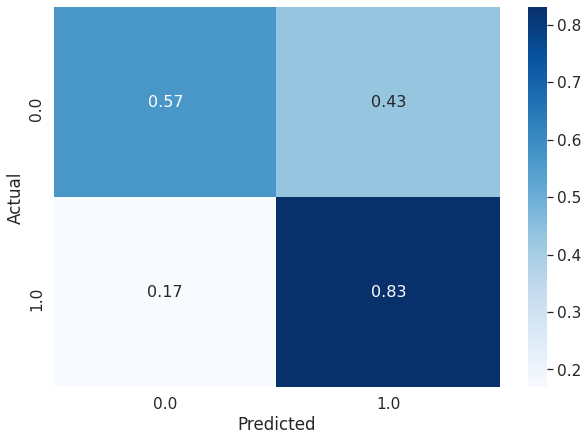

In [139]:
import seaborn as sns
df_cm = pd.DataFrame(matrix_norm, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size